In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [3]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

In [4]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['Coadded_2dGauss_and_Airy_Params.npz'
 'Coadded_2dGauss_and_Airy_Params_18mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_20mcut.npz'
 'Coadded_2dGauss_and_Airy_Params_25mcut.npz'
 'FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FL

In [5]:
### Let's take a median value per flight for what this correction should be:
## I already know which frequencies are good now after lots of checking, use good_freqs above stored in yaml

pols = N_pols
print(pols)

for fly in Npolflights[1::]:
    thingy=[]
    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    apkls = glob.glob(ampdir+'*'+fly+'*.pkl')[0]
    with open(apkls, 'rb') as inp:
        ampdata = pickle.load(inp)
    
    for p in pols:
        thingy.append(np.nanmedian(ampdata[good_freqs,p],axis=0))
    print('Flight: ',fly,' Amplitude Correction: ', np.nanmedian(thingy))
    
#pols = E_pols
#print(pols)
#
#for fly in Epolflights[1::]:
#    thingy=[]
#    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish
#
#    apkls = glob.glob(ampdir+'*'+fly+'*.pkl')[0]
#    with open(apkls, 'rb') as inp:
#        ampdata = pickle.load(inp)
#    
#    for p in pols:
#        thingy.append(np.nanmedian(ampdata[good_freqs,p],axis=0))
#    print('Flight: ',fly,' Amplitude Correction: ', np.nanmedian(thingy))

[1, 3, 9, 11, 15]
Flight:  619  Amplitude Correction:  0.9870000000000008
Flight:  625  Amplitude Correction:  1.006000000000001
Flight:  646  Amplitude Correction:  0.7860000000000006
Flight:  647  Amplitude Correction:  0.7400000000000005
Flight:  533  Amplitude Correction:  0.4800000000000003
Flight:  536  Amplitude Correction:  0.6940000000000005


# Read in a single co-added beam pickle and plot maps, slices

[538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938]


<ipython-input-6-89beb651a918>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


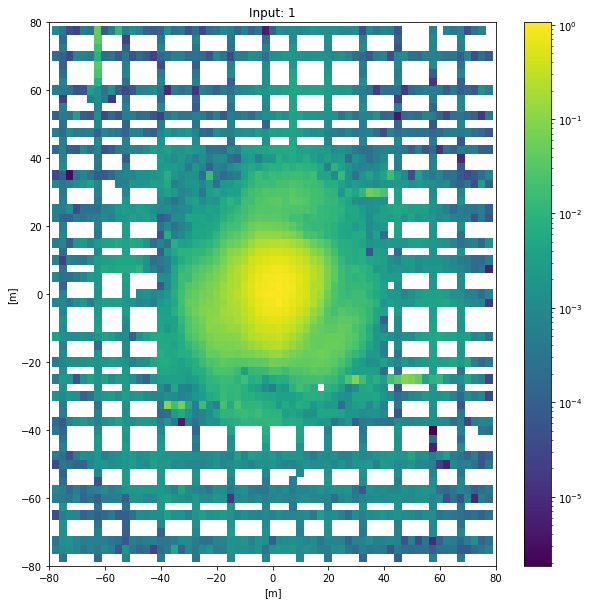

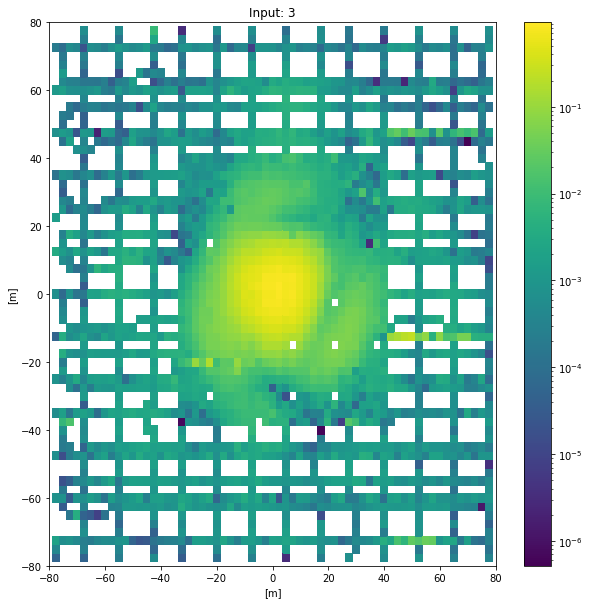

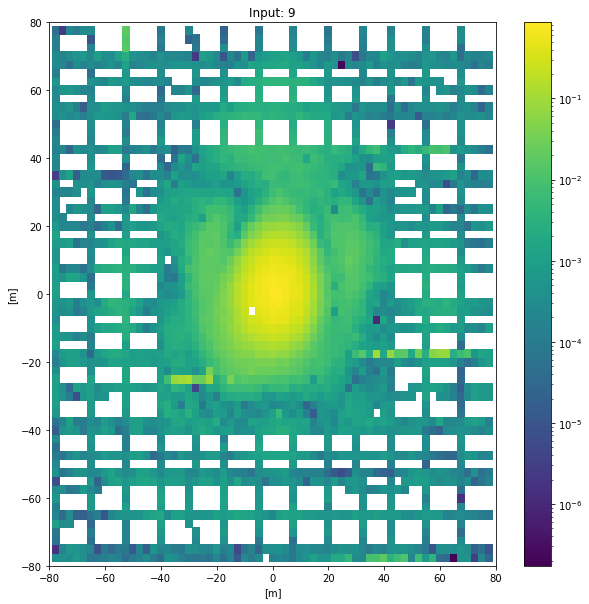

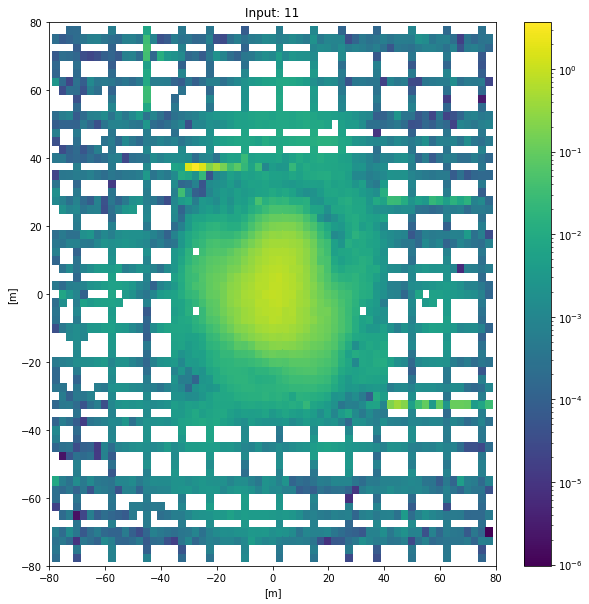

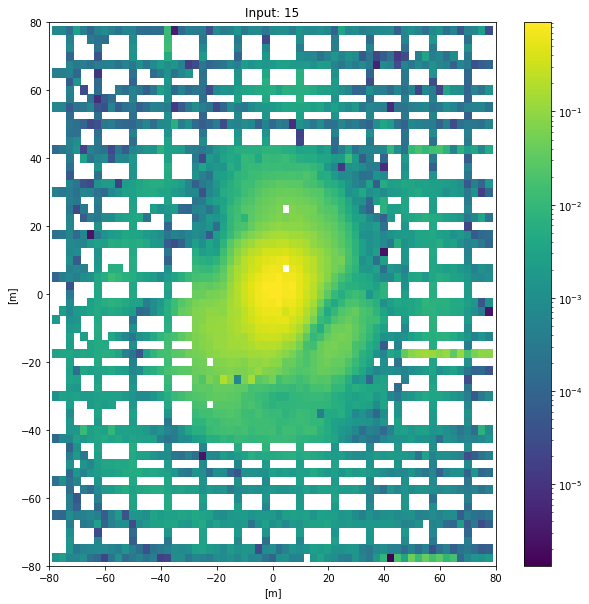

<ipython-input-6-89beb651a918>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


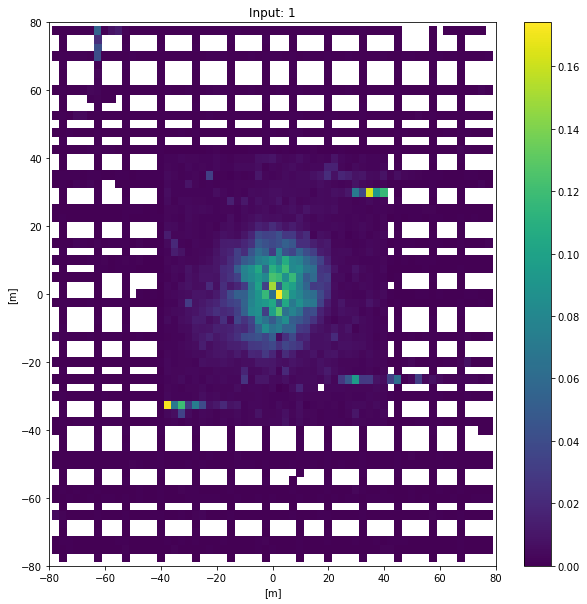

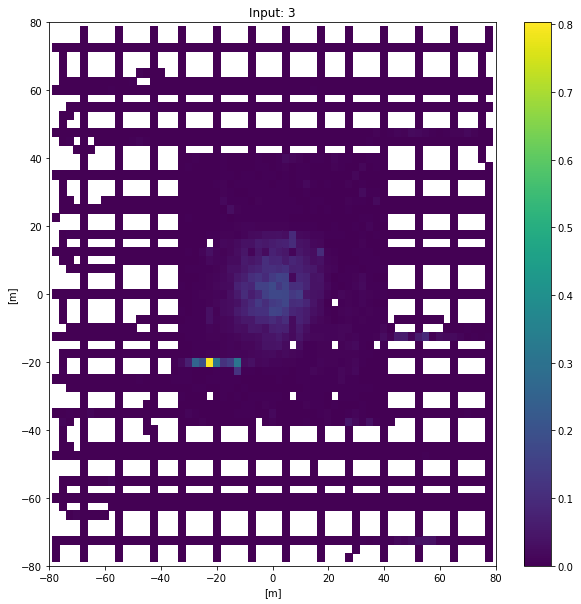

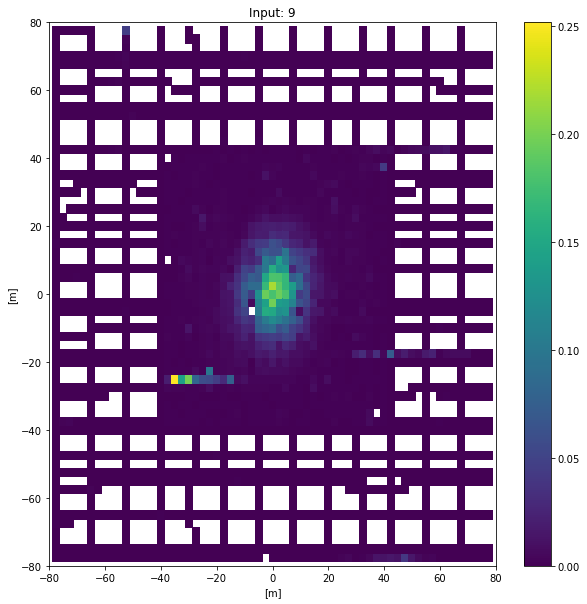

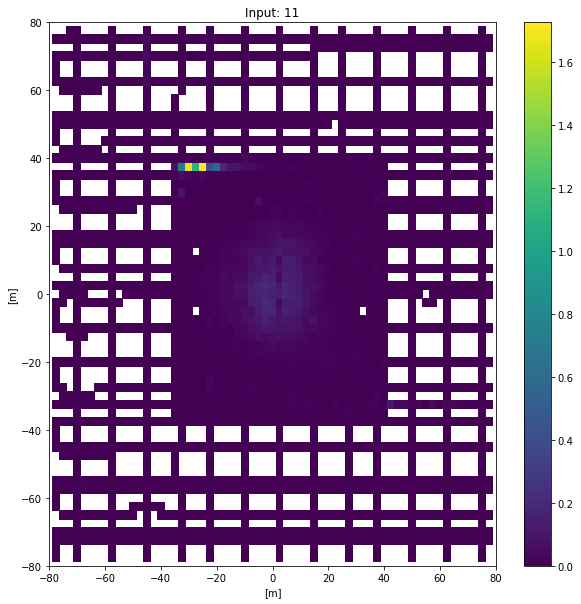

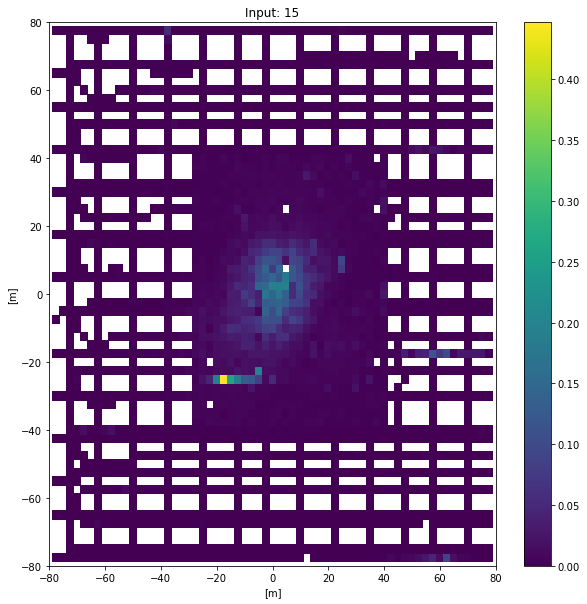

In [6]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = good_freqs[0]
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.viridis)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    


# Gaussian fit the co-added maps above

In [7]:
#restr = 18
# read in all N pol co-adds

print(good_freqs)
G_popt = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


[538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938]


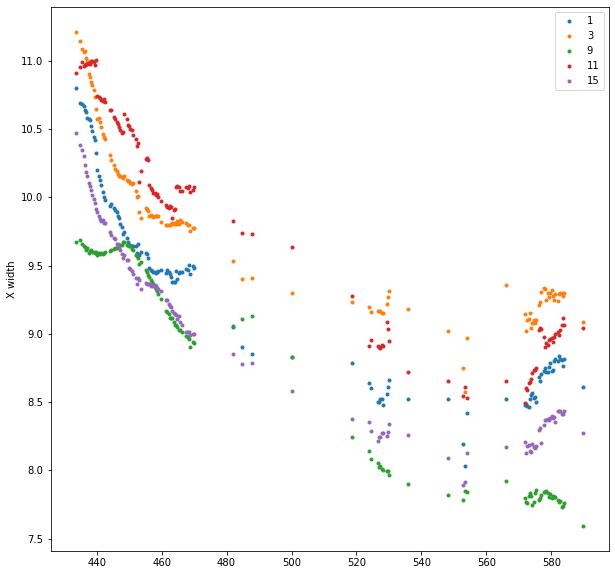

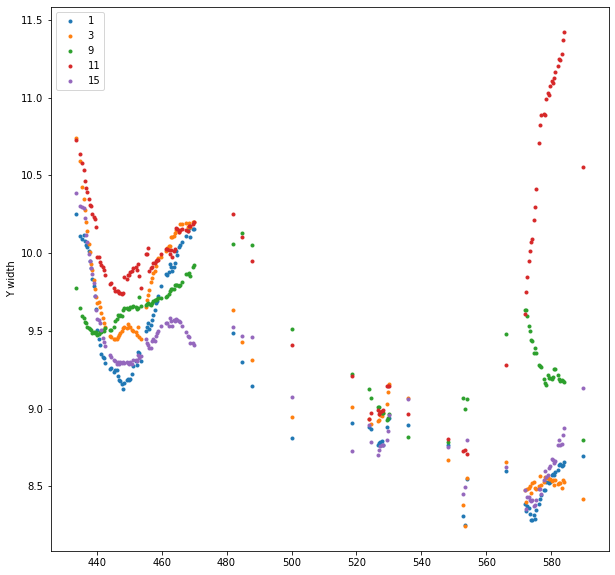

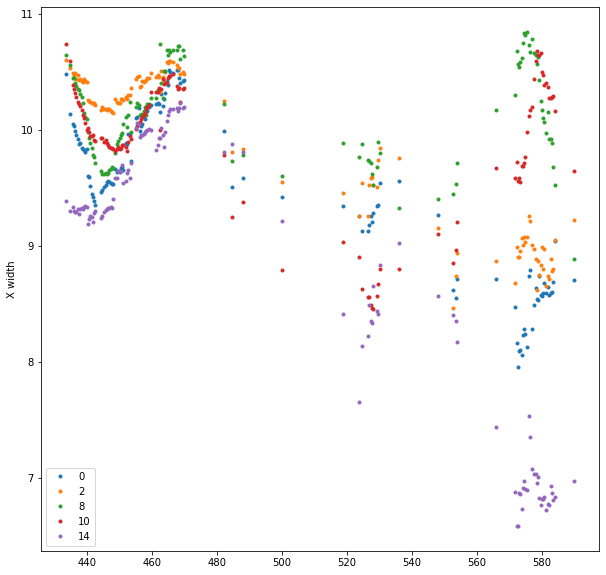

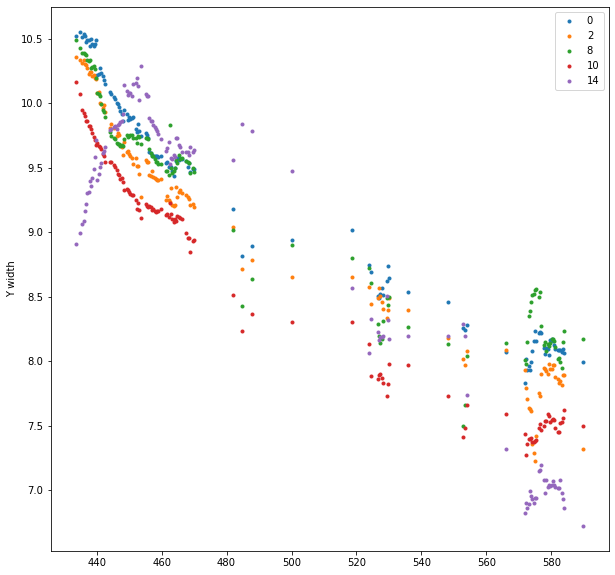

In [8]:
pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

In [9]:
# Average flights together to compare

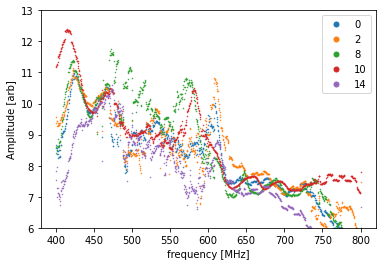

In [10]:

coadded = np.zeros([16,1024,6])

pols = N_pols
flights = ['618','619']
datastore = np.zeros([16,1024,6,len(flights)])
for f,fly in enumerate(flights):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for j, chind in enumerate(pols): 
        datastore[chind,:,:,f] = fits['G_popt'][chind,:,0:6]
coadded[pols,:,:] = np.mean(datastore[pols,:,:],axis=-1)

   
pols = E_pols
flights = flights = ['620']
datastore = np.zeros([16,1024,6,len(flights)])
for f,fly in enumerate(flights):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    for j, chind in enumerate(pols): 
        datastore[chind,:,:,f] = fits['G_popt'][chind,:,0:6]
coadded[pols,:,:] = np.mean(datastore[pols,:,:],axis=-1)


for j,chind in enumerate(pols):
    plt.plot(freqs,coadded[chind,:,2],marker='.',markersize=1,linestyle='None',label=str(chind))
plt.ylim(6,13)
plt.xlabel('frequency [MHz]')
plt.ylabel('Amplitude [arb]')
plt.legend(markerscale=10)
plt.show()

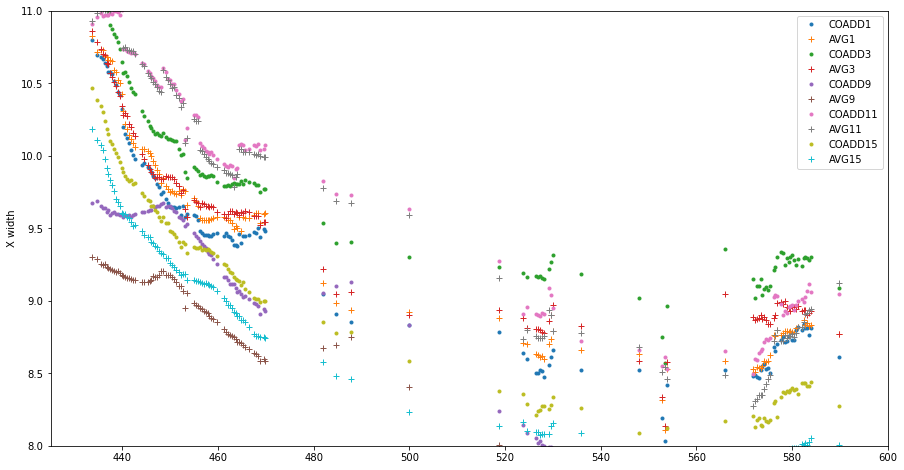

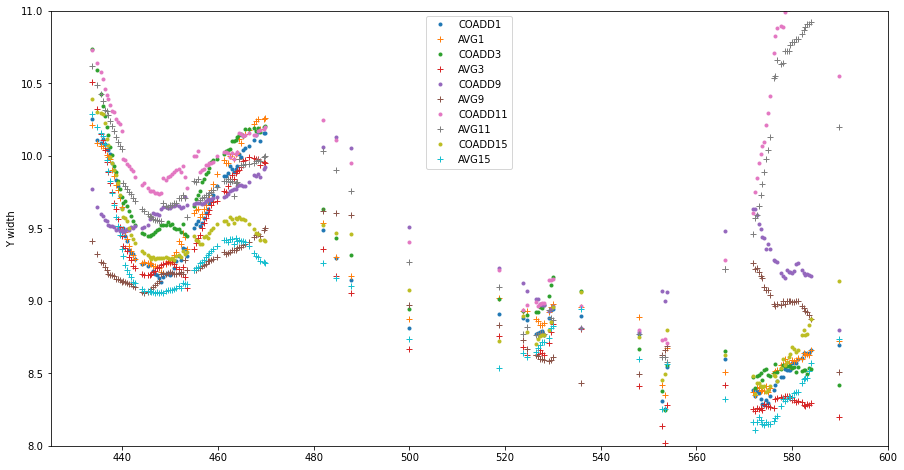

In [25]:
pols = N_pols

fig = plt.figure(figsize=(15,8))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label='COADD'+str(pp))
    plt.plot(freqs[good_freqs],coadded[pp,good_freqs,2],marker='+',linestyle='None',label='AVG'+str(pp))
plt.ylabel('X width')
plt.ylim(8,11)
plt.xlim(425,600)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,8))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label='COADD'+str(pp))
    plt.plot(freqs[good_freqs],coadded[pp,good_freqs,4],marker='+',linestyle='None',label='AVG'+str(pp))
plt.ylabel('Y width')
plt.ylim(8,11)
plt.xlim(425,600)
plt.legend()
plt.show()



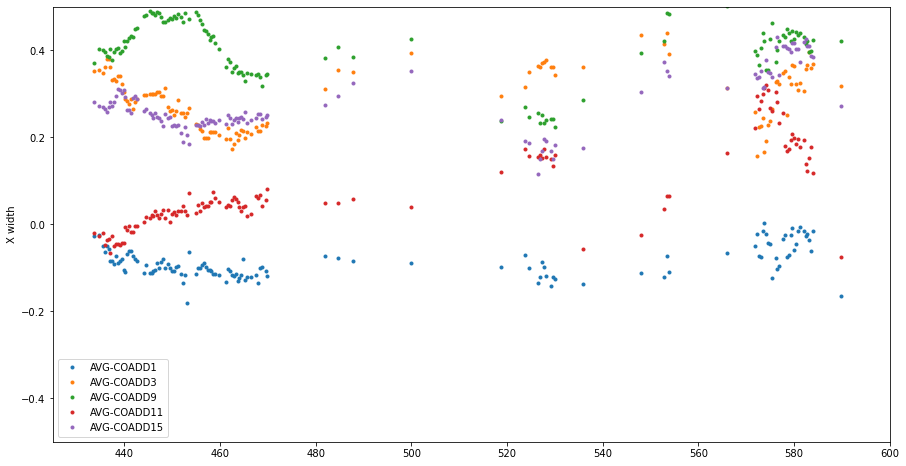

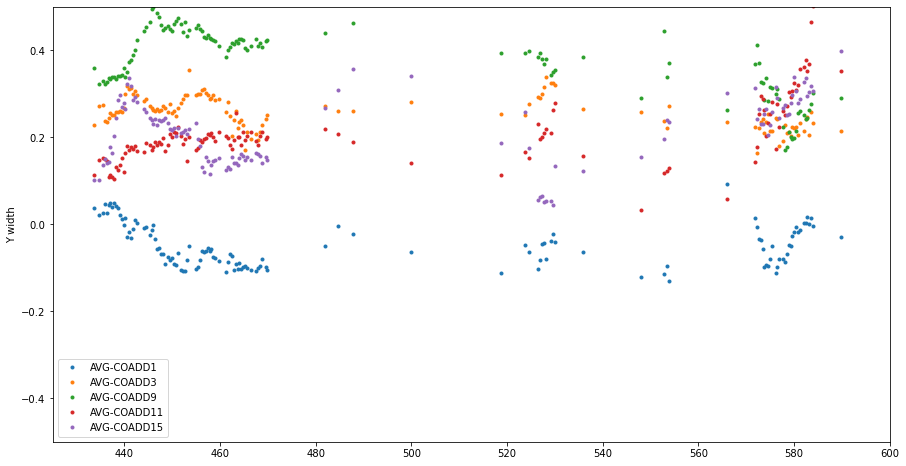

In [28]:
pols = N_pols

fig = plt.figure(figsize=(15,8))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2]-coadded[pp,good_freqs,2],marker='.',linestyle='None',label='AVG-COADD'+str(pp))
plt.ylabel('X width')
plt.ylim(-0.5,0.5)
plt.xlim(425,600)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,8))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4]-coadded[pp,good_freqs,4],marker='.',linestyle='None',label='AVG-COADD'+str(pp))
plt.ylabel('Y width')
plt.ylim(-0.5,0.5)
plt.xlim(425,600)
plt.legend()
plt.show()

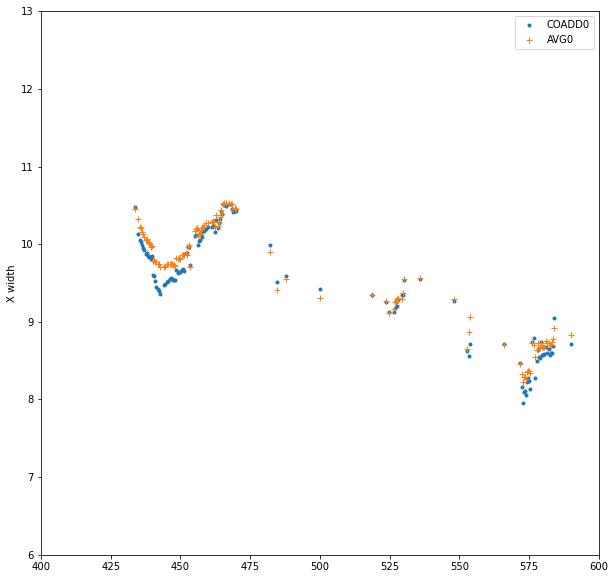

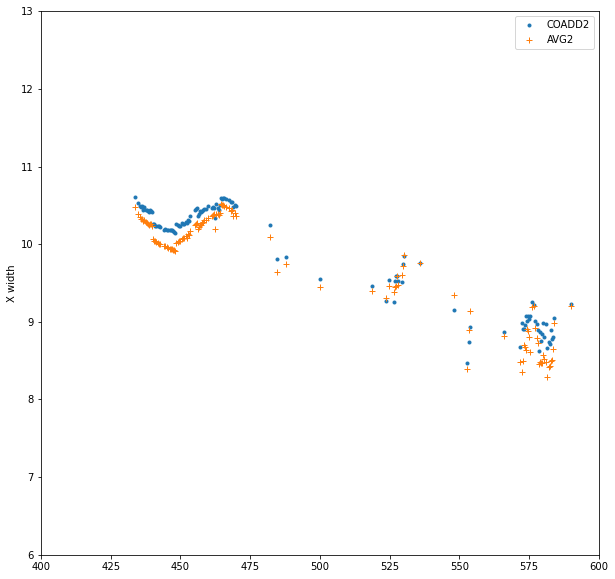

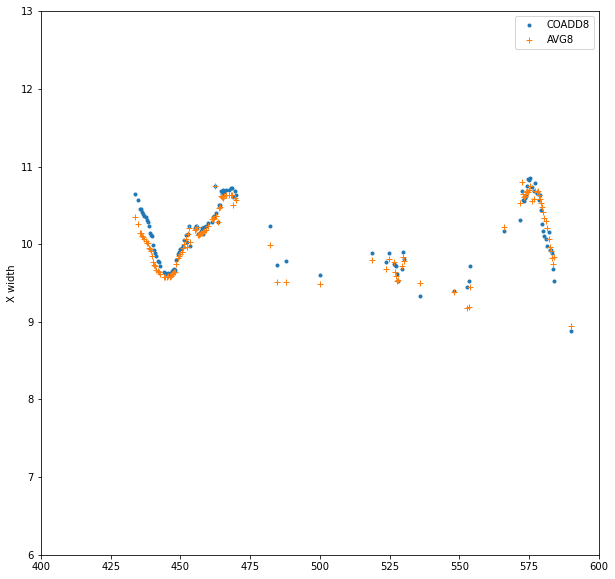

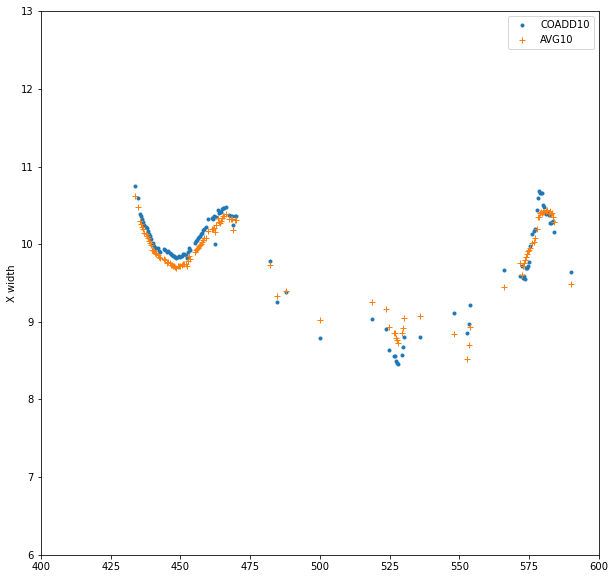

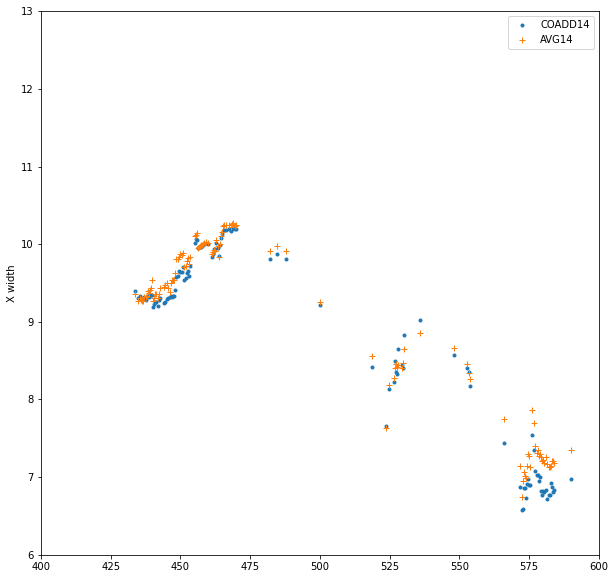

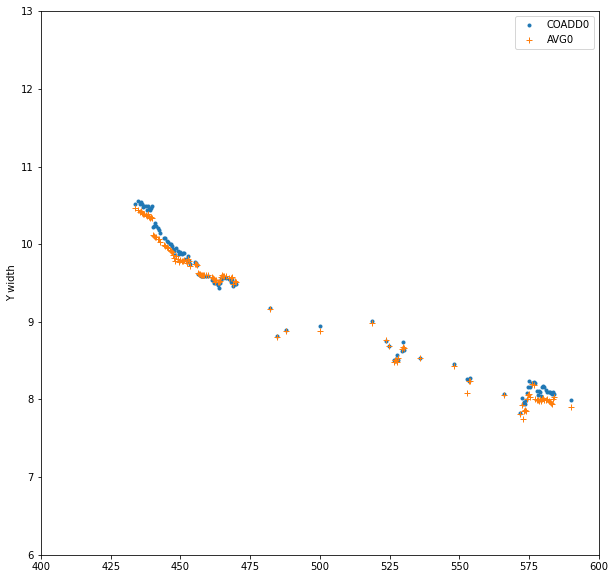

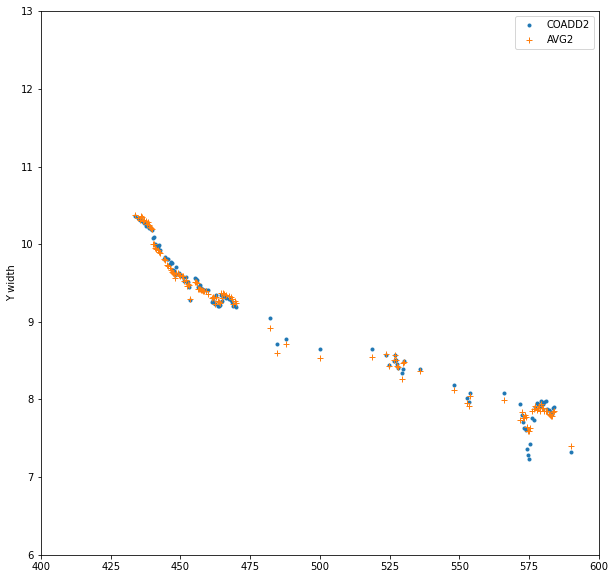

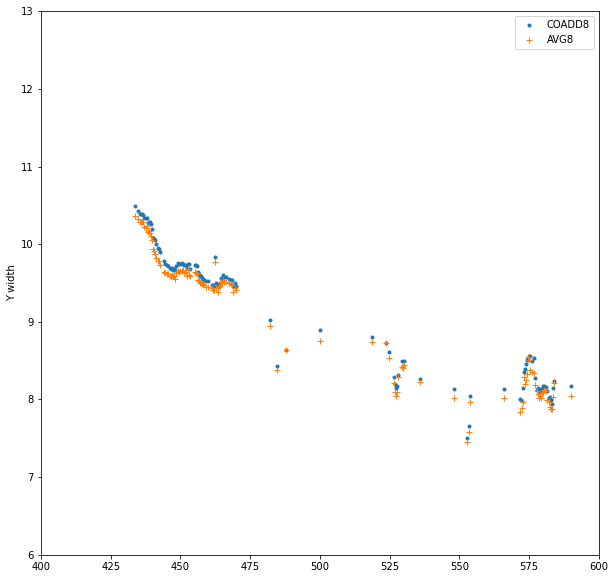

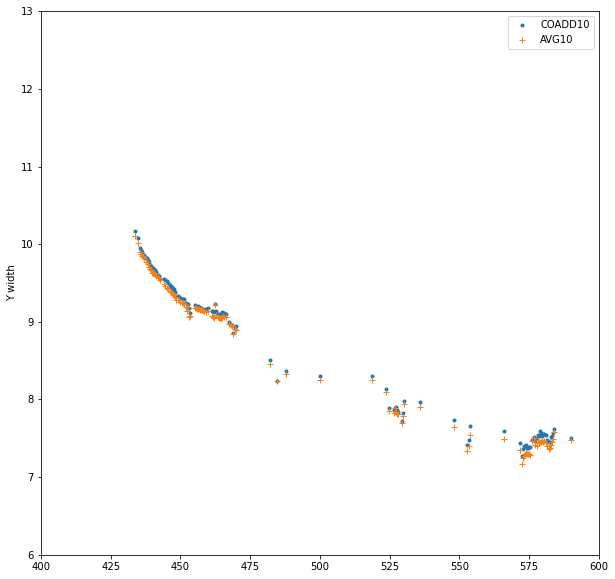

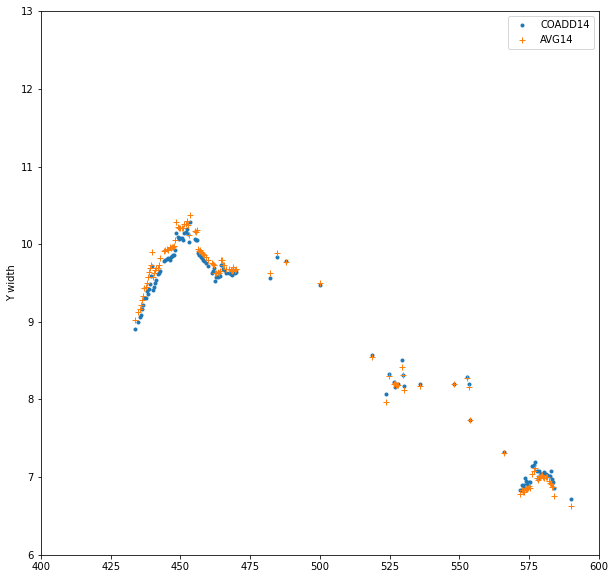

In [12]:
pols = E_pols
for p,pp in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label='COADD'+str(pp))
    plt.plot(freqs[good_freqs],coadded[pp,good_freqs,2],marker='+',linestyle='None',label='AVG'+str(pp))
    plt.ylabel('X width')
    plt.ylim(6,13)
    plt.xlim(400,600)
    plt.legend()
    plt.show()
    
for p,pp in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label='COADD'+str(pp))
    plt.plot(freqs[good_freqs],coadded[pp,good_freqs,4],marker='+',linestyle='None',label='AVG'+str(pp))
    plt.ylabel('Y width')
    plt.ylim(6,13)
    plt.xlim(400,600)
    plt.legend()
    plt.show()

In [ ]:
# We like the fits to the co-add, lets save then as a numpy array:

# save
tmpfitpath='/hirax/GBO_Analysis_Outputs/main_beam_fits/Coadded_2dGauss_and_Airy_Params.npz'
np.savez(tmpfitpath,G_popt=G_popt)     

# check
fits = np.load(tmpfitpath)

pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['G_popt'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

In [16]:
fits['coadded']

array([[[ 0.00000000e+00,  0.00000000e+00,  6.00000000e+00,
          0.00000000e+00,  6.00000000e+00,  0.00000000e+00],
        [ 1.92088397e-09, -1.57200298e+00,  4.04296194e+00,
          6.07730141e+00,  3.38519965e+00,  1.81427477e-12],
        [ 1.91744152e-09, -1.58774838e+00,  4.02059970e+00,
          6.11454432e+00,  3.37193986e+00,  1.84196990e-12],
        ...,
        [ 9.18669654e-10, -3.67971442e+00,  8.57048574e+00,
          1.72249769e+00,  8.59196905e+00, -2.51157859e-13],
        [ 8.90883343e-10, -3.77907037e+00,  8.57032624e+00,
          1.72018813e+00,  8.48239654e+00,  3.29645522e-13],
        [ 8.60546737e-10, -3.15150973e+00,  8.67652906e+00,
          1.73396477e+00,  8.53400966e+00, -3.91903974e-12]],

       [[ 7.83945752e-09, -4.29823407e+00,  8.96923048e+00,
          5.99380862e-01,  9.04654788e+00,  3.74095895e-12],
        [ 3.49606839e-10, -5.55915574e+00,  7.86530308e+00,
          6.98520830e-02,  3.98208657e+00,  7.93329343e-13],
        [ 3.81136

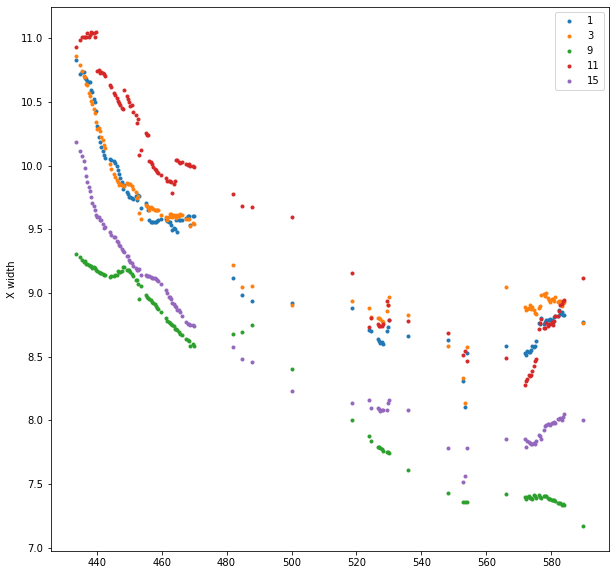

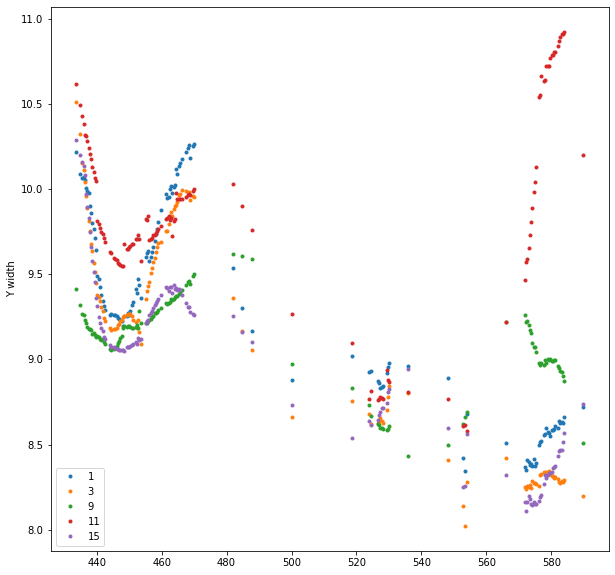

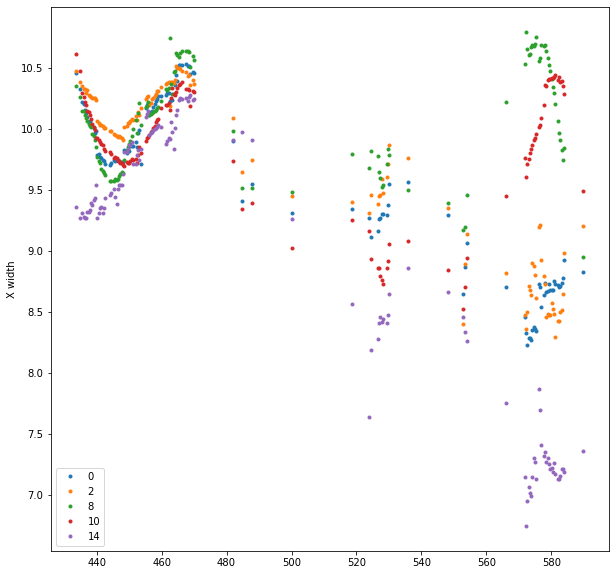

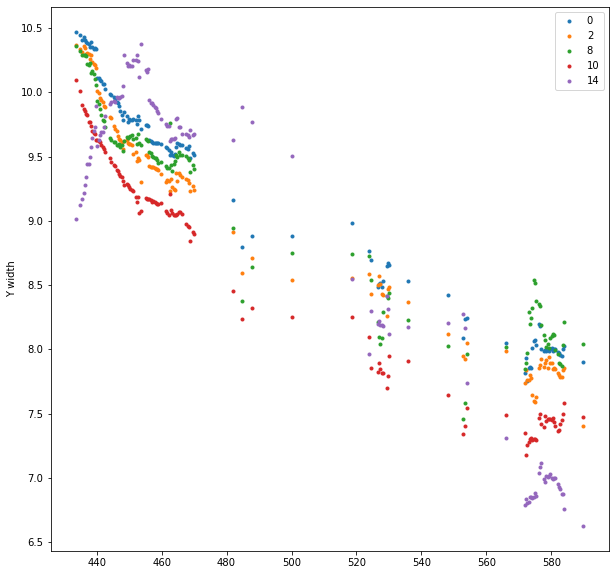

In [17]:
# We like the fits to the co-add, lets save then as a numpy array:

# save
tmpfitpath='/hirax/GBO_Analysis_Outputs/main_beam_fits/Averaged_2dGauss_and_Airy_Param.npz'
np.savez(tmpfitpath,coadded=coadded)     

# check
fits = np.load(tmpfitpath)

pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['coadded'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['coadded'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['coadded'][pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],fits['coadded'][pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

# Check the class works for auto-processing

In [ ]:

find = 932
print(freqs[find])

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))

flights = Npolflights
pols=N_pols
chind=pols[0]
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]    


beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='std',mask=True,Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1])


In [ ]:
pols = E_pols
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               beam.V_LC_operation_err[:,:,0,chind],cmap=cm.viridis)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    


In [ ]:
# MAPPS ::: take slice at x = 0
xx = 0
colx = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(beam.y_centers_grid[:,colx,0],beam.V_LC_operation[colx,:,0,chind].T,'o',
             label='x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(beam.x_centers_grid[coly,:,0],beam.V_LC_operation[:,coly,0,chind].T,'o',
             label='y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
# ERRORS:::: take slice at x = 0
xx = 0
colx = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(beam.y_centers_grid[:,colx,0],(beam.V_LC_operation_err[colx,:,0,chind].T),'o',
             label='x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(beam.x_centers_grid[coly,:,0],beam.V_LC_operation_err[:,coly,0,chind].T,'o',
             label='y : '+str(beam.y_centers_grid[coly,0,0]))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
# take slice at x = 0
xx = 0
colx = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.errorbar(beam.y_centers_grid[:,colx,0],np.log10(beam.V_LC_operation[colx,:,0,chind].T),
                 yerr=np.log10(beam.V_LC_operation_err[colx,:,0,chind].T),
             label='x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(beam,beam.V_LC_operation[:,:,0,chind],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    plt.errorbar(beam.x_centers_grid[coly,:,0],np.log10(beam.V_LC_operation[:,coly,0,chind].T),
                 yerr=np.log10(beam.V_LC_operation_err[:,coly,0,chind].T),
             label='y : '+str(beam.y_centers_grid[coly,0,0]))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

# FREQUENCY SELECTION 


# Initial frequency selection, to decide which frequencies to plot slices of:
# Read in the amplitude pickles, select based on high median values, 
# amplitudes that bottomed out, or amplitudes that are too high

In [ ]:

# lets tally the frequencies we don't want to use
Nbadfreqs = []
Ebadfreqs = []

In [ ]:
ampdir='/home/ln267/newburghlabdrone/analysis/amppickles/'


In [ ]:
# Lets's start wi N pol:
pols = N_pols

for fly in Npolflights[1::]:
    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    apkls = glob.glob(ampdir+'*618*'+fly+'*')
    for apkl in apkls:
        with open(apkl, 'rb') as inp:
            ampdata = pickle.load(inp)
        gfs = np.where(ampdata[0,:,pols[0]] != 0)
        amps[:,gfs,:] = ampdata[:,gfs,:]
        
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[0,:,chind])
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(pols):
        for g in np.arange(512,1024):
            if amps[0,g,chind] == 0.1 or  amps[0,g,chind] >2.8 or amps[1,g,chind] >6E-5: Nbadfreqs.append(g)

In [ ]:
# Now E pol flights:
pols = E_pols

for fly in Epolflights[1::]:
    amps = np.zeros([4,1024,16]) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish

    apkls = glob.glob(ampdir+'*620*'+fly+'*')
    for apkl in apkls:
        with open(apkl, 'rb') as inp:
            ampdata = pickle.load(inp)
        gfs = np.where(ampdata[0,:,pols[0]] != 0)
        amps[:,gfs,:] = ampdata[:,gfs,:]
        
    fig = plt.figure(figsize=(15,10))
    for j,chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[0,:,chind])
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Amp [norm]')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,amps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(pols):
        for g in np.arange(512,1024):
            if amps[0,g,chind] == 0.1 or  amps[0,g,chind] > 2.8 or amps[1,g,chind] >6E-5: Ebadfreqs.append(g)

In [ ]:
badfreqs = Nbadfreqs + Ebadfreqs

# get unique frequencies per array
uu = np.array(Nbadfreqs)
Nbad_uniq = np.unique(uu)

uu = np.array(Ebadfreqs)
Ebad_uniq = np.unique(uu)

uu = np.array(badfreqs)
bad_uniq = np.unique(uu)

plt.plot(Nbad_uniq)
plt.plot(Ebad_uniq)
plt.plot(bad_uniq)
plt.show()

print(len(Nbad_uniq),len(Ebad_uniq),len(bad_uniq))


freqm = np.zeros(1024)

freqm[bad_uniq] = 1.0

good_uniq = np.where(freqm==0.0)[0][512::]

fig = plt.figure(figsize=(15,10))
plt.plot(freqs[bad_uniq],freqm[bad_uniq],'r.')
plt.plot(freqs[good_uniq],freqm[good_uniq],'g.')
plt.xlim(400,600)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Mask')

print('BAD FREQUENCY INDICES: ',  bad_uniq)
print('GOOD FREQUENCY INDICES: ', good_uniq)



In [ ]:
# compare this with the zeros in the waterfall from the raw data for flight 648

waterfall = [585,586,587, 588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,
  614,  616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,
  629,  641,  643,  644,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,
  657,  658,  659,  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
  671,  672,  673,  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,
  686,  687,  688,  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,
  717,  718,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,
  747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
  761,  762,  763,  764,  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,
  776,  777,  778,  779,  780,  781,  782,  783,  811,  812,  813,  815,  816,  817,
  818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,
  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  995,
  996,  998, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

In [ ]:
picklezero = [ 540,  541,  542,  543,  544,  545,  546,  550,  552,  574,  585,  586,  587,  588,
  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,  600,  601,  602,  603,
  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,  614,  616,  617,  618,
  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,  629,  638,  641,  643,
  646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,  671,  672,  673,
  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,
  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,  717,  721,  722,
  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,  749,  750,
  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,  776,  777,  778,  779,
  780,  781,  782,  783,  797,  812,  813,  815,  816,  817,  818,  819,  820,  821,
  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,
  836,  837,  838,  839,  840,  841,  842,  843,  844,  934,  936,  938,  939,  940,
  942,  943,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,  956,
  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,  983,  984,
  985,  986,  987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

In [ ]:
freqm = np.zeros(1024)
freqm[bad_uniq] = 1.0

freqw = np.zeros(1024)
freqw[waterfall] = 0.9

freqp = np.zeros(1024)
freqp[picklezero] = 0.8

fig = plt.figure(figsize=(16,8))
plt.plot(freqs,freqw,'ro',markersize=3,label='Flagged in waterfall')
plt.plot(freqs,freqp,'g+',markersize=2,label='Flagged from picklezero')
plt.plot(freqs,freqm,'bs',markersize=4,label='Flagged from median')
plt.xlim(400,600)
plt.legend()
plt.show()

print(len(good_uniq))

# Investigate various flight combinations
# --------------------------------------------------
# Keep for historical reasons: Look at flight differences from 618 or 620, compute median in annulus as a fucntion of freq

In [ ]:
# Check out the normalizations getting applied
norms = np.zeros([1024,16,len(pflights)])
stats = np.zeros([1024,16,len(pflights)])
#norms = np.zeros([32,16,len(pflights)])
for i, fly in enumerate(pflights): 
    print(fly)
    if fly == '618': norms[:,:,i] = 1.0 
    elif fly == '620': norms[:,:,i] = 1.0 
    elif fly in Npolflights[1::]:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
            #gdf = np.where(fpstat[0,:,chind]!=0)
        norms[:,:,i] = fpstat[0,:,:]
        stats[:,:,i] = fpstat[1,:,:]
    elif fly in Epolflights[1::]:
        print('in Epol flights')
        pklfile = 'Flight_620'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
            #gdf = np.where(fpstat[0,:,chind]!=0)
        norms[:,:,i] = fpstat[0,:,:]
        stats[:,:,i] = fpstat[1,:,:]




In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs,norms[:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        plt.ylim(0.1,1.1)
        plt.legend()
plt.show()     

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs,stats[:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        #plt.ylim(0.1,1.1)
        plt.legend()
plt.show()     



In [ ]:
# read in all files and apply normalization

flightarr = np.zeros([64,64,32,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,32,16,len(pflights)])

for i, fly in enumerate(pflights):
    
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[512,1024,16],f_index=find,vplot=False)
    
    if fly == '618': 
        normarr[:,:,:,:,i] = 1.0
    elif fly == '620': 
        normarr[:,:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,len(beam.faxis)):
                normarr[:,:,f,d,i] = fpstat[0,beam.faxis[f],d]
    elif fly in Epolflights[1::]:
        pklfile = 'Flight_620'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,len(beam.faxis)):
                normarr[:,:,f,d,i] = fpstat[0,beam.faxis[f],d]
    
    print(fly, norm)
    flightarr[:,:,:,:,i] = beam.V_LC_mean[:,:,:,:,0]*normarr[:,:,:,:,i]


In [ ]:
#bfs = [736,832,592,752,816,806,656,672,688]
bfs = [592,608,656,688,736,752,816,832]
bfs = [544,592,608,624,656,672,688,736,752,816,832,960,976,992,1008]

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs[(beam.faxis)],normarr[0,0,:,chind,i],marker='o',linestyle='None',label=str(fly))
        #plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.xlim(400,600)
        plt.ylim(0.1,3.0)
        plt.legend()
        for bf in bfs:
            plt.axvline(freqs[bf],color='black')
plt.show() 

In [ ]:
## Create masks:

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingy = np.logical_and(thingyx.mask,thingyy.mask)
outer_mask = np.logical_not(thingy)

full_mask = np.logical_or(inner_mask,outer_mask)



In [ ]:
statarr = np.zeros([32,16,len(pflights)])

for i, fly in enumerate(pflights):
    print(fly)
    diff = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,i]
    
    for d in np.arange(0,16):
        for f in np.arange(0,len(beam.faxis)):
            maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
            statarr[f,d,i] = get_stat(maskdiff,'mednoabs')


In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(pflights):
        plt.plot(freqs[(beam.faxis)],statarr[:,chind,i],marker='o',alpha=0.6,label=str(fly))
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
        plt.legend()
plt.show()

# Epol flights only: combine into 46, 40, and 36dB flights, annulus mask, and compute/plot

In [ ]:
fly_46db = flightarr[:,:,:,:,0]
fly_40db = np.nanmean(flightarr[:,:,:,:,1:3],axis=-1)
fly_36db = flightarr[:,:,:,:,3]

In [ ]:
statarr = np.zeros([32,16,3])
itr = 0

for d in np.arange(0,16):
    for f in np.arange(0,32):
        # 46-40
        diff = fly_46db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,0] = get_stat(maskdiff,'mednoabs')
        # 46-36
        diff = fly_46db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,1] = get_stat(maskdiff,'mednoabs')
        # 40-36
        diff = fly_40db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,2] = get_stat(maskdiff,'mednoabs')

In [ ]:
pairs = ['46-40','46-36','40-36']

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,3):
        plt.plot(freqs[(beam.faxis)],statarr[:,chind,i],marker='o',alpha=0.6,label=pairs[i])
        plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,3):
        plt.semilogy(freqs[(beam.faxis)],np.abs(statarr[:,chind,i]),marker='o',alpha=0.6,label=pairs[i])
        plt.xlabel('Freq [MHz]')
        plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

In [ ]:
find=768#640#896#992#900#570#800#900
f_intern = int((find-512)/16)

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_46db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('46dB flights')
plt.show()


fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_40db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('40dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(E_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_36db[:,:,f_intern,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('36dB flights')
plt.show()

In [ ]:
for find in [528,576,704,720,768,784,800,848,864,880,896,928,944]:

    f_intern = int((find-512)/16)

    # take slice at x = 0
    xx = 0
    colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(E_pols):
        plt.subplot(3,2,j+1) 
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_46db[colx,:,f_intern,chind].T,'o',
             label='46dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_40db[colx,:,f_intern,chind].T,'o',
             label='40dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.semilogy(beam.y_centers_grid[:,colx,0],fly_36db[colx,:,f_intern,chind].T,'o',
             label='36dB  x :'+str(beam.x_centers_grid[0,colx,0]))
        plt.title('Input: '+str(chind))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.legend()
    plt.show()

    xx = 0
    coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(E_pols):
        plt.subplot(3,2,j+1)
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_46db[:,coly,f_intern,chind].T,'o',
             label='46db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_40db[:,coly,f_intern,chind].T,'o',
             label='40db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.semilogy(beam.x_centers_grid[coly,:,0],fly_36db[:,coly,f_intern,chind].T,'o',
             label='36db y : '+str(beam.y_centers_grid[coly,0,0]))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
        plt.title('Input: '+str(chind))
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.legend()
    plt.show()

# Npol flights only: Combine into 46, 43, 40, and 36dB flights, annulus mask, and compute median


In [ ]:
fly_46db = np.nanmean(flightarr[:,:,:,:,0:3],axis=-1)
fly_43db = flightarr[:,:,:,:,6]
fly_40db = np.nanmean(flightarr[:,:,:,:,3:5],axis=-1)
fly_36db = flightarr[:,:,:,:,5]

In [ ]:
statarr = np.zeros([32,16,6])
itr = 0

for d in np.arange(0,16):
    for f in np.arange(0,32):
        # 46-43
        diff = fly_46db[:,:,:,:] - fly_43db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,0] = get_stat(maskdiff,'mednoabs')
        # 46-40
        diff = fly_46db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,1] = get_stat(maskdiff,'mednoabs')
        # 46-36
        diff = fly_46db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,2] = get_stat(maskdiff,'mednoabs')
        # 43-40
        diff = fly_43db[:,:,:,:] - fly_40db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,3] = get_stat(maskdiff,'mednoabs')
        # 43-36
        diff = fly_43db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,4] = get_stat(maskdiff,'mednoabs')
        # 40-36
        diff = fly_40db[:,:,:,:] - fly_36db[:,:,:,:]
        maskdiff = np.ma.masked_where(full_mask, diff[:,:,f,d]).filled(np.nan)
        statarr[f,d,5] = get_stat(maskdiff,'mednoabs')
        

In [ ]:
pairs = ['46-43','46-40','46-36','43-40','43-36','40-36']

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,6):
        plt.plot(freqs[gdf],statarr[:,chind,i],marker='o',alpha=0.6,label=pairs[i])
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    for i in range(0,6):
        plt.semilogy(freqs[gdf],np.abs(statarr[:,chind,i]),marker='o',alpha=0.6,label=pairs[i])
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('Median of differenced map')
        plt.grid()
        plt.title('Input: '+str(chind))
        plt.ylim(-2E-3,2E-3)
plt.legend()
plt.show()

# Investigate differences between the 46dB flights


In [ ]:
flightarr = np.zeros([64,64,32,16,3]) # pixel, pixel, freq, dish, Nflights
find = 992

for i, fly in enumerate(Npolflights[0:3]):
    normarr = np.zeros([64,64,32,16])
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[512,1024,16],f_index=find,vplot=False)
    
    if fly == '618': 
        normarr[:,:,:,:] = 1.0
    else:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        
        for d in np.arange(0,16):
            for f in np.arange(0,32):
                normarr[:,:,f,d] = fpstat[0,beam.faxis[f],d]
    
    print(fly, norm)
    flightarr[:,:,:,:,i] = beam.V_LC_mean[:,:,:,:,0]*normarr[:,:,:,:]


In [ ]:
diff1819 = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,1]
diff1825 = flightarr[:,:,:,:,0] - flightarr[:,:,:,:,2]
diff1925 = flightarr[:,:,:,:,1] - flightarr[:,:,:,:,2]

high = 10 # inner mask, 20 for large flights
low = -10 # inner mask, 20 for large flights
maskin = high # annulus mask, set equal to high
maskout = 20 # annulus mask, 50 for large flights

## Create masks:

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)

thingyx = np.ma.masked_inside(beam.x_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingyy = np.ma.masked_inside(beam.y_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingy = np.logical_and(thingyx.mask,thingyy.mask)
outer_mask = np.logical_not(thingy)

full_mask = np.logical_or(inner_mask,outer_mask)

# Look at inner masking for flight 625
statarr = np.zeros([32,16,3])

for d in np.arange(0,16):
    for f in np.arange(0,32):
            mask1819 = np.ma.masked_where(outer_mask, diff1819[:,:,f,d]).filled(np.nan)
            mask1825 = np.ma.masked_where(outer_mask, diff1825[:,:,f,d]).filled(np.nan)
            mask1925 = np.ma.masked_where(outer_mask, diff1925[:,:,f,d]).filled(np.nan)
            statarr[f,d,0] = get_stat(mask1819,'mednoabs')
            statarr[f,d,1] = get_stat(mask1825,'mednoabs')
            statarr[f,d,2] = get_stat(mask1925,'mednoabs')

In [ ]:
# useful to remember which frequencies I computed norms for...
gfr = np.where(fpstat[0,:,chind] !=0)[0]
print(gfr)
print(freqs[gfr],len(gfr))

In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.plot(freqs[beam.faxis],statarr[:,chind,0],marker='o',label='Flight 1618 - 1619')
    plt.plot(freqs[beam.faxis],statarr[:,chind,1],marker='o',label='Flight 1618 - 1625')
    plt.plot(freqs[beam.faxis],statarr[:,chind,2],marker='o',label='Flight 1619 - 1625')
    plt.xlabel('Freq [MHz]')
    plt.ylabel('Median of differenced map')
    plt.title('Inner region only - 46dB flights')
    plt.grid()
plt.legend()
plt.show()

In [ ]:
# for 625 only, what would I get if I masked the inner region and minimized the nanmedian?

normspe = np.zeros([32,16])

for f in np.arange(0,32):
    for chind in N_pols:
        statarr = np.zeros(len(nss))
        for i in np.arange(0,len(nss)):
            ns = nss[i]
            diffn = get_beam_diff(flightarr[:,:,f,chind,0], flightarr[:,:,f,chind,2],ns)
            new_d = np.ma.masked_where(outer_mask, diffn).filled(np.nan)
            statarr[i] = get_stat(new_d,'median')

        mm = np.argmin(statarr)
        normspe[f,chind] = nss[mm]



In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    plt.plot(freqs[gdf],normspe[:,chind],marker='o',label='Using inner region')
    plt.plot(freqs[gdf],norms[:,chind,2],marker='o',label='using annulus')
    plt.ylim(0.5,1.5)
    plt.legend()
    plt.title('Input '+str(chind))
plt.show()

# Investigate a single frequency

In [ ]:
find=640#896#992#900#570#800#900
ff = int((find - 512) / 16)

normflights = np.zeros([64,64,16,len(Npolflights)])

for i, fly in enumerate(Npolflights):
    
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on    

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find,vplot=False)

    if fly == '618': norm = 1.0 
    else:
        pklfile = 'Flight_618'+'-Flight'+str(fly)+'_norms.pkl'
        print(pklfile)

        with open(pklfile, 'rb') as inp:
            fpstat = pickle.load(inp)
        norm = fpstat[0,find,:]
    print(fly, norm)
    normflights[:,:,:,i] = beam.V_LC_mean[:,:,f_intern,:,0]*norm

    #fig = plt.figure(figsize=(15,10))
    #for i,p in enumerate(pols):
    #    plt.subplot(3,2,i+1)
    #    plt.plot(freqs,fpstat[0,:,p],marker='.',linestyle='None',label='median')
    #    plt.plot(freqs,fpstat[1,:,p],marker='.',linestyle='None',label='stddev')
    #    plt.plot(freqs,fpstat[2,:,p],marker='.',linestyle='None',label='sum')
    #    plt.xlim(400,600)
    #    plt.ylim(0.1,1.5)
    #    plt.text(410,1.3,' Input: '+str(p))
    #    plt.axhline(1.0,color='black',ls='--')
    #plt.legend(loc='upper right')
    #plt.xlabel('frequency [MHz]')
    #plt.ylabel('Relative normalization')
    #plt.suptitle('Flights: '+fly1+' and '+fly2)
    #plt.show()



In [ ]:
# take slice at x = 0
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    xx = 0
    colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(Npolflights):
        plt.semilogy(beam.y_centers_grid[:,colx,0],normflights[colx,:,chind,i].T,'o',
             label='Flight '+str(fly)+' x : '+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    xx = 0
    coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    plt.subplot(3,2,j+1)
    for i, fly in enumerate(Npolflights):
        plt.semilogy(beam.x_centers_grid[coly,:,0],normflights[:,coly,chind,i].T,'o',
             label='Flight '+str(fly)+' y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.ylim(0.001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
# average similar attenuations together first

fly_46db = np.nanmean(normflights[:,:,:,0:3],axis=-1)
fly_43db = normflights[:,:,:,6]
fly_40db = np.nanmean(normflights[:,:,:,3:5],axis=-1)
fly_36db = normflights[:,:,:,5]

In [ ]:
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_46db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('46dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_43db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('43dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_40db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('40dB flights')
plt.show()

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               fly_36db[:,:,chind].T,cmap=cm.gnuplot2,vmax=1.1,vmin=0.001,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    plt.colorbar()
plt.suptitle('36dB flights')
plt.show()

In [ ]:
# take slice at x = 0
xx = 0
colx = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_46db[colx,:,chind].T,'o',
             label='46dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_43db[colx,:,chind].T,'o',
             label='43dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_40db[colx,:,chind].T,'o',
             label='40dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.semilogy(beam.y_centers_grid[:,colx,0],fly_36db[colx,:,chind].T,'o',
             label='36dB  x :'+str(beam.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(beam,beam.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(N_pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_46db[:,coly,chind].T,'o',
             label='46db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_43db[:,coly,chind].T,'o',
             label='43db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_40db[:,coly,chind].T,'o',
             label='40db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.semilogy(beam.x_centers_grid[coly,:,0],fly_36db[:,coly,chind].T,'o',
             label='36db y : '+str(beam.y_centers_grid[coly,0,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [ ]:
diff = get_beam_diff(fly_46db[:,:,chind], fly_43db[:,:,chind],1.0)

plt.pcolormesh(beam.x_centers_grid[:,:,chind],beam.y_centers_grid[:,:,chind],
               np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.colorbar()
plt.show()

